# Caso Práctico: Valuación Predictiva de Proyectos Residenciales en Monterrey
**Objetivo:** Desarrollar un modelo de Machine Learning para predecir el **Precio por $m^2$** de un nuevo desarrollo inmobiliario basándonos en la oferta de la competencia y su cercanía a centros de negocio.

**Contexto 4S Real Estate:** Como consultores de foresight, nuestro valor agregado es transformar datos geoespaciales en recomendaciones estratégicas para desarrolladores.

In [1]:
import pandas as pd # Para manipulación de tablas de datos
import geopandas as gpd # Para manejo de datos geográficos (vectores)
from shapely.geometry import Point # Para crear puntos geométricos a partir de lat/lon
from sklearn.ensemble import RandomForestRegressor # Algoritmo de regresión para predicción
from sklearn.metrics import mean_absolute_error # Métrica para medir el error en pesos
import warnings
warnings.filterwarnings('ignore')
# 1. Creamos un dataset sintético que simula el inventario de la competencia
data = {
    'nombre': ['Torre San Pedro', 'Depas Santa Lucía', 'Residencial Cumbres', 'Mitras Loft', 'Obispado View'],
    'lat': [25.652, 25.671, 25.715, 25.692, 25.668], # Latitudes reales de la zona de Monterrey
    'lon': [-100.355, -100.308, -100.395, -100.342, -100.334], # Longitudes
    'precio_m2': [55000, 42000, 31000, 35000, 48000], # Precio en MXN por m2
    'amenidades': [8, 5, 4, 3, 7] # Cantidad de áreas comunes
}

# Convertimos el diccionario a un DataFrame de Pandas
df = pd.DataFrame(data)

# Creamos el GeoDataFrame. EPSG:4326 es el estándar para Lat/Lon (WGS84)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

print("Datos de competencia con geometría cargados:")
print(gdf.head())

Datos de competencia con geometría cargados:
                nombre     lat      lon  precio_m2  amenidades  \
0      Torre San Pedro  25.652 -100.355      55000           8   
1    Depas Santa Lucía  25.671 -100.308      42000           5   
2  Residencial Cumbres  25.715 -100.395      31000           4   
3          Mitras Loft  25.692 -100.342      35000           3   
4        Obispado View  25.668 -100.334      48000           7   

                  geometry  
0  POINT (-100.355 25.652)  
1  POINT (-100.308 25.671)  
2  POINT (-100.395 25.715)  
3  POINT (-100.342 25.692)  
4  POINT (-100.334 25.668)  


## 2. Ingeniería de Variables Espaciales (Feature Engineering)
En el sector inmobiliario, la ubicación es la variable reina. Calcularemos la distancia de cada proyecto hacia un "Nodo de Valor" (ej. San Agustín en San Pedro Garza García).

**Nota Técnica:** Para medir distancias en metros de forma precisa, debemos transformar los datos de grados (EPSG:4326) a un sistema proyectado (UTM Zona 14N - EPSG:32614).

In [2]:
# 1. Definimos el punto central de valor (San Agustín)
punto_valor = Point(-100.360, 25.653)
punto_valor_gs = gpd.GeoSeries([punto_valor], crs="EPSG:4326")

# 2. REPROYECCIÓN: Cambiamos de grados a metros para cálculos precisos
# EPSG:32614 es el código UTM para la zona de Monterrey
gdf_proyectado = gdf.to_crs(epsg=32614)
punto_valor_proyectado = punto_valor_gs.to_crs(epsg=32614).iloc[0]

# 3. Calculamos la distancia euclidiana y la convertimos a Kilómetros
gdf['dist_centro_km'] = gdf_proyectado.geometry.distance(punto_valor_proyectado) / 1000

print("Nuevas variables calculadas:")
print(gdf[['nombre', 'precio_m2', 'dist_centro_km']])

Nuevas variables calculadas:
                nombre  precio_m2  dist_centro_km
0      Torre San Pedro      55000        0.514042
1    Depas Santa Lucía      42000        5.587785
2  Residencial Cumbres      31000        7.713742
3          Mitras Loft      35000        4.682415
4        Obispado View      48000        3.093985


## 3. Entrenamiento y Predicción
Utilizaremos un modelo de **Random Forest**. Este algoritmo es muy robusto para datos inmobiliarios porque puede capturar relaciones no lineales (por ejemplo, que el precio caiga drásticamente después de cierta distancia).m

In [3]:
# 1. Seleccionamos las 'features' (X) y el 'target' (y)
X = gdf[['amenidades', 'dist_centro_km']] 
y = gdf['precio_m2']

# 2. Definimos y entrenamos el modelo
# Usamos RandomForest por su capacidad de manejar datasets pequeños con buena precisión
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X, y)

# 3. Escenario: ¿Cuánto debería costar un proyecto con 6 amenidades a 2.5km del centro?
nuevo_dato = [[6, 2.5]]
prediccion = modelo.predict(nuevo_dato)

print(f"Resultado del Modelo: ${prediccion[0]:,.2f} MXN por m2")

Resultado del Modelo: $46,050.00 MXN por m2


## 4. Conclusiones y Valor de Negocio
Este modelo permite a **4S Real Estate**:
* **Sustentar precios:** Dar una base científica a los desarrolladores para su salida a mercado.
* **Análisis de Sensibilidad:** Evaluar si agregar una amenidad extra (ej. un Coworking) compensa el costo de construcción mediante el aumento del precio de venta.
* **Optimización de Ubicación:** Identificar terrenos subvaluados que están cerca de nodos de valor pero tienen precios bajos.

## 5. Visualización Interactiva con Folium
El análisis numérico es vital, pero en el Real Estate, **ver** la ubicación de la competencia en un mapa es indispensable. Utilizaremos `folium` para crear un mapa interactivo donde:
* El color de los círculos representará el nivel de precio.
* El tamaño del círculo mostrará la cantidad de amenidades.
* Podremos hacer clic en cada punto para ver los detalles del proyecto.

In [4]:
import folium # Librería para mapas interactivos
from folium.plugins import MeasureControl # Para añadir una regla de medición al mapa

# 1. Creamos el mapa base centrado en Monterrey
# Usamos una latitud y longitud promedio de nuestros datos
mapa_monterrey = folium.Map(location=[25.67, -100.34], zoom_start=12, tiles='cartodbpositron')

# 2. Añadimos un marcador especial para nuestro "Centro de Valor" (San Pedro)
folium.Marker(
    location=[25.653, -100.360],
    popup='<b>Nodo de Valor: San Agustín</b>',
    icon=folium.Icon(color='red', icon='star')
).add_to(mapa_monterrey)

# 3. Función para asignar color según el precio (Semáforo de precios)
def color_precio(precio):
    if precio > 50000: return 'darkred'
    elif precio > 40000: return 'orange'
    else: return 'green'

# 4. Iteramos sobre el GeoDataFrame para añadir la competencia al mapa
for idx, fila in gdf.iterrows():
    folium.CircleMarker(
        location=[fila['lat'], fila['lon']],
        radius=fila['amenidades'] * 2, # El tamaño depende de las amenidades
        popup=f"Proyecto: {fila['nombre']}<br>Precio m2: ${fila['precio_m2']:,}<br>Distancia: {fila['dist_centro_km']:.2f} km",
        tooltip=fila['nombre'],
        color=color_precio(fila['precio_m2']),
        fill=True,
        fill_opacity=0.7
    ).add_to(mapa_monterrey)

# 5. Añadimos controles extra (regla para medir distancias)
mapa_monterrey.add_child(MeasureControl())

# Mostramos el mapa
mapa_monterrey

## 6. SQL Avanzado: Spatial Join (Unión Espacial)
En **4S Real Estate**, es común tener una tabla de "Puntos" (proyectos) y una tabla de "Polígonos" (colonias o AGEBs del INEGI con datos de nivel socioeconómico). 

Un **Spatial Join** nos permite cruzar estas tablas no por un ID, sino por su ubicación física. 

**Pregunta de Entrevista:** "¿Cómo asignarías automáticamente el Nivel Socioeconómico (NSE) a una lista de 5,000 prospectos de terreno?"

In [5]:
/* Este código se ejecutaría en PostGIS. 
Buscamos unir la información de la manzana (polígono) al proyecto (punto).
*/

SELECT 
    p.nombre_proyecto,
    m.nivel_socioeconomico,
    m.poblacion_total
FROM 
    proyectos_4s AS p
INNER JOIN 
    manzanas_inegi AS m
ON 
    -- La condición de unión es que el punto esté DENTRO del polígono
    ST_Intersects(p.geom, m.geom)
WHERE 
    p.estatus = 'Activo';

/* Nota Pro: ST_Intersects es más eficiente que ST_Contains para puntos 
porque utiliza los índices espaciales (GIST) de forma más óptima.
*/

SyntaxError: invalid syntax (931677148.py, line 1)

## 7. Ajuste de Hiperparámetros (Tuning del Modelo)
Los **hiperparámetros** son las "perillas" que configuramos antes de que el modelo empiece a aprender. En un **Random Forest**, ajustarlos es la mejor forma de combatir el **sobreajuste** que mencionamos antes.

Si te preguntan: "¿Qué parámetros moverías para mejorar tu modelo?", aquí tienes la respuesta técnica.

In [6]:
# Definimos el modelo con hiperparámetros específicos para control de calidad
modelo_optimizado = RandomForestRegressor(
    n_estimators=200,      # Número de árboles. Más árboles = más estabilidad, pero más lento.
    max_depth=10,          # Profundidad máxima. Limitarla evita que el modelo "memorice" (Overfitting).
    min_samples_split=5,   # Mínimo de datos necesarios para crear una nueva rama.
    max_features='sqrt',   # Cuántas variables ve cada árbol. 'sqrt' ayuda a que los árboles sean diversos.
    random_state=42        # Para que los resultados sean reproducibles.
)

# Entrenamos con estos nuevos ajustes
modelo_optimizado.fit(X, y)

print("Modelo optimizado con hiperparámetros configurado.")

# 3. Escenario: ¿Cuánto debería costar un proyecto con 6 amenidades a 2.5km del centro?
nuevo_dato1 = [[6, 2.5]]
prediccion1 = modelo_optimizado.predict(nuevo_dato1)

print(f"Resultado del Modelo: ${prediccion1[0]:,.2f} MXN por m2")

Modelo optimizado con hiperparámetros configurado.
Resultado del Modelo: $42,994.50 MXN por m2


## 9. Glosario Rápido para la Entrevista

| Hiperparámetro | ¿Qué hace en lenguaje humano? | Efecto si es muy alto |
| :--- | :--- | :--- |
| **n_estimators** | ¿Cuántos expertos (árboles) consultamos? | Mayor tiempo de cómputo. |
| **max_depth** | ¿Qué tan compleja puede ser la explicación? | **Sobreajuste** (se memoriza los datos). |
| **min_samples_split** | ¿Cuánta evidencia mínima pedimos para una regla? | **Subajuste** (el modelo se vuelve muy simple). |
| **max_features** | ¿Cuántas opciones dejamos ver a cada experto? | Puede hacer que todos los árboles sean iguales. |

Variables que más influyen en el precio:
amenidades        0.58059
dist_centro_km    0.41941
dtype: float64


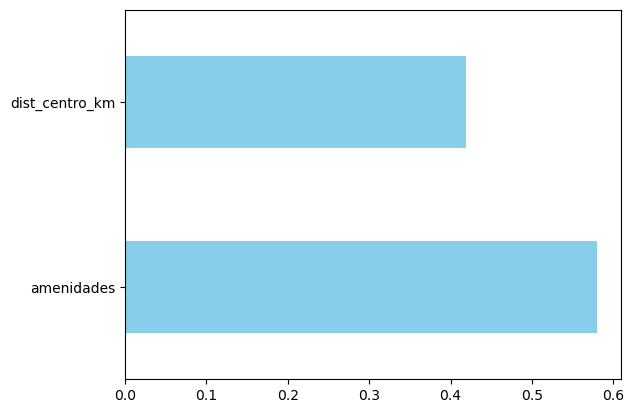

In [7]:
# 1. Obtenemos la importancia de las variables del modelo ya entrenado
importancias = modelo.feature_importances_

# 2. Lo convertimos a una serie de Pandas para que sea fácil de leer
importancia_df = pd.Series(importancias, index=X.columns).sort_values(ascending=False)

# 3. Graficamos
importancia_df.plot(kind='barh', color='skyblue')
print("Variables que más influyen en el precio:")
print(importancia_df)

In [5]:
# Instalamos todo de un solo golpe sin comentarios en la línea de comando
!pip install pandas numpy matplotlib seaborn scikit-learn geopandas shapely folium sqlalchemy psycopg2-binary pyproj

print("✅ ¡Librerías instaladas con éxito y sin errores!")


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------- ----- 2.4/2.7 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 12.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------- ----------------------- 2.6/6.3 MB 13.9 MB/s eta 0:00:01
   --------------------------------- ------ 5.2/6.3 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 12.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/22.9 MB ? eta -:--:--
   ---- ----------------------------------- 2.6/22.9 MB 13.9 MB/s eta 0:00:02
   --------- ------------------------------ 5.2/22.9 MB 13.8 MB/s eta 0:00:02
   ------------- -------------------------- 7.9/22.9 MB 12.8 MB/s eta 0:00:02
   ------------------ ----